t=1000인 경우

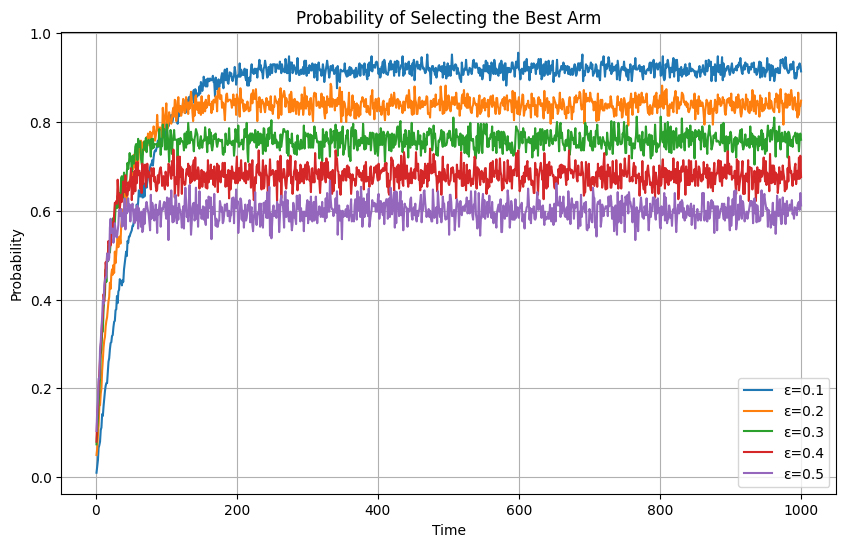

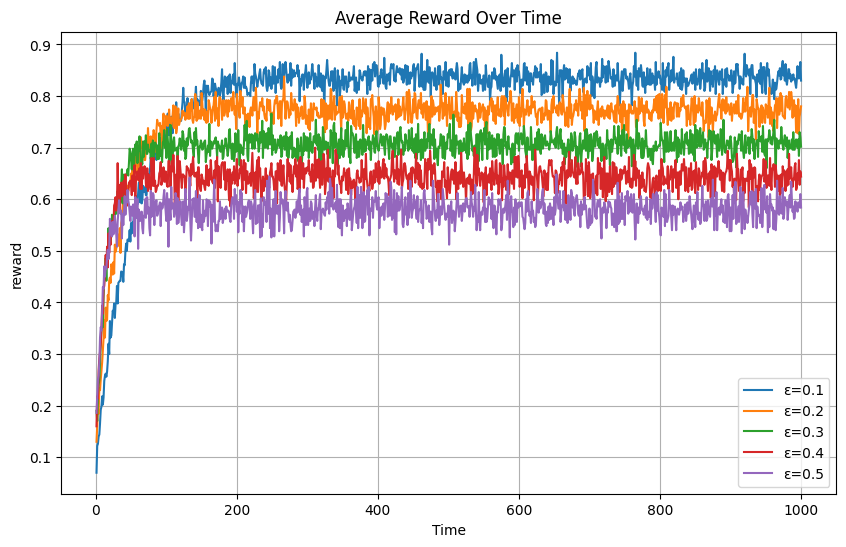

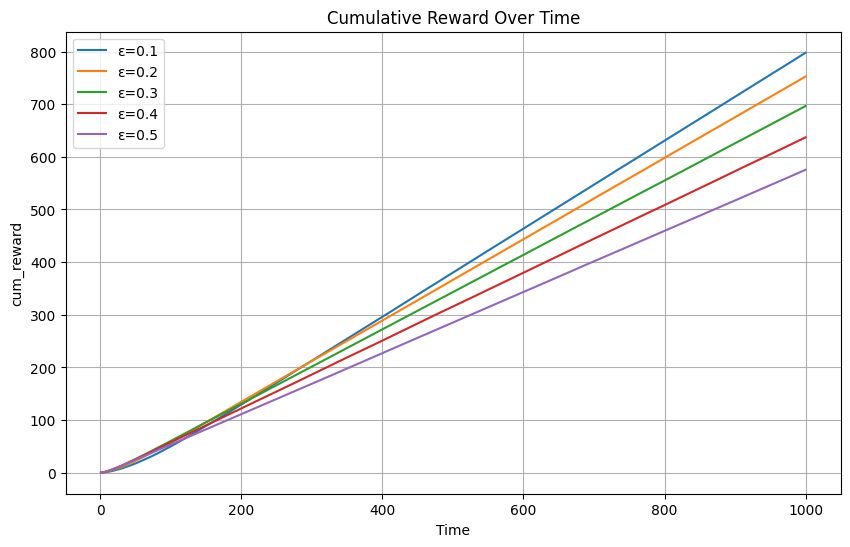

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# 1. Bernoulli Arm
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# 2. Epsilon-Greedy (고정)
class EpsilonGreedy():
    def __init__(self, epsilon):
        self.epsilon = epsilon
    def initialize(self, n_arms):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
    def select_arm(self):
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1)/n)*value + (1/n)*reward

# 3. Test Framework
def test_algorithm(algo, arms, num_sims, horizon, label):
    result = {"experiment": [], "sim": [], "time": [], "arm": [], "reward": [], "cum_reward": []}
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total = 0.0
        for t in range(1, horizon + 1):
            arm = algo.select_arm()
            reward = arms[arm].draw()
            algo.update(arm, reward)
            total += reward
            result["experiment"].append(label)
            result["sim"].append(sim)
            result["time"].append(t)
            result["arm"].append(arm)
            result["reward"].append(reward)
            result["cum_reward"].append(total)
    return pd.DataFrame(result)

# 실험 환경
random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
random.shuffle(means)
arms = [BernoulliArm(p) for p in means]
best_arm = means.index(max(means))
num_sims, horizon = 500, 1000

# 실험 실행
df_list = []
for eps in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(eps)
    df_list.append(test_algorithm(algo, arms, num_sims, horizon, f"ε={eps}"))
df_all = pd.concat(df_list)

# 시각화
def plot_metric(df, metric, title):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        y = subset.groupby("time")[metric].mean()
        plt.plot(y.index, y.values, label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(metric)
    plt.legend()
    plt.grid()
    plt.show()

def plot_best_arm_prob(df, best_arm):
    plt.figure(figsize=(10, 6))
    for label in df["experiment"].unique():
        subset = df[df["experiment"] == label]
        prob = subset.groupby("time")["arm"].apply(lambda x: sum(x == best_arm) / len(x))
        plt.plot(prob.index, prob.values, label=label)
    plt.title("Probability of Selecting the Best Arm")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

# 그래프 출력
plot_best_arm_prob(df_all, best_arm)
plot_metric(df_all, "reward", "Average Reward Over Time")
plot_metric(df_all, "cum_reward", "Cumulative Reward Over Time")


Time-Varying Epsilon 실험 (증가 / 감소)
- ε 값을 시간에 따라 스케줄링 (250/500/1000 기준)

- 두 실험:

  - 증가: ε = 0.1 → 0.3 → 0.5

  - 감소: ε = 0.5 → 0.3 → 0.1

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class EpsilonGreedySchedule:
    def __init__(self, schedule):
        """
        schedule: {time_step: epsilon_value} 형태의 dict
        (time_step 이하까지 해당 epsilon 사용)
        """
        self.schedule = schedule

    def initialize(self, n_arms):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.t = 0  # 시간 추적용

    def select_arm(self):
        self.t += 1  # 현재 시간 업데이트
        epsilon = self.get_epsilon(self.t)
        if random.random() > epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

    def get_epsilon(self, t):
        # 시간에 따라 epsilon 반환
        sorted_keys = sorted(self.schedule.keys())
        for k in sorted_keys:
            if t <= k:
                return self.schedule[k]
        return self.schedule[sorted_keys[-1]]  # 가장 마지막 값을 기본으로


In [ ]:
df1 = test_algorithm(
    EpsilonGreedySchedule({250: 0.1, 500: 0.3, 1000: 0.5}),
    arms,
    num_sims,
    horizon,
    "ε: 0.1 → 0.3 → 0.5"
)

df2 = test_algorithm(
    EpsilonGreedySchedule({250: 0.5, 500: 0.3, 1000: 0.1}),
    arms,
    num_sims,
    horizon,
    "ε: 0.5 → 0.3 → 0.1"
)

df_sched = pd.concat([df1, df2])


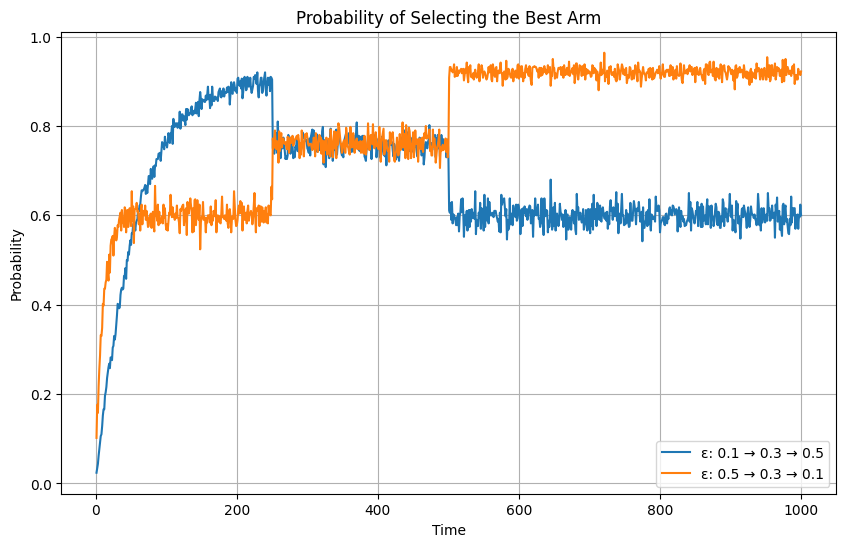

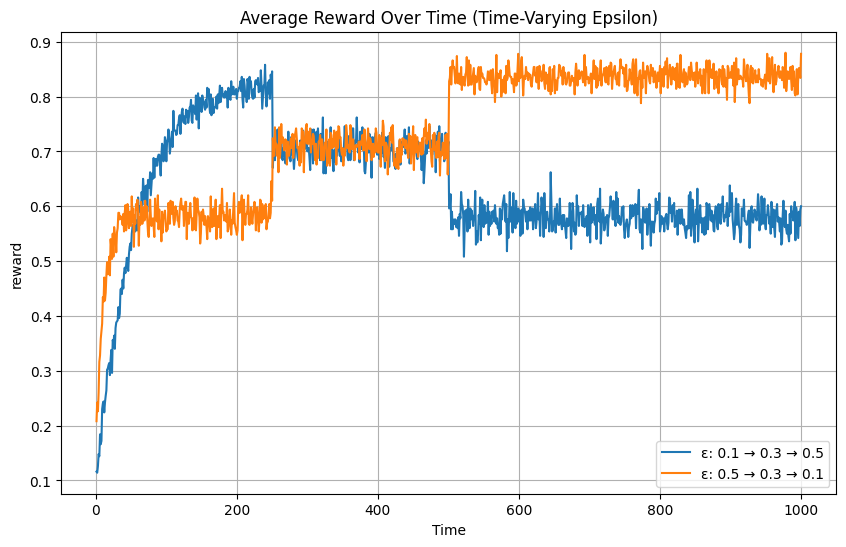

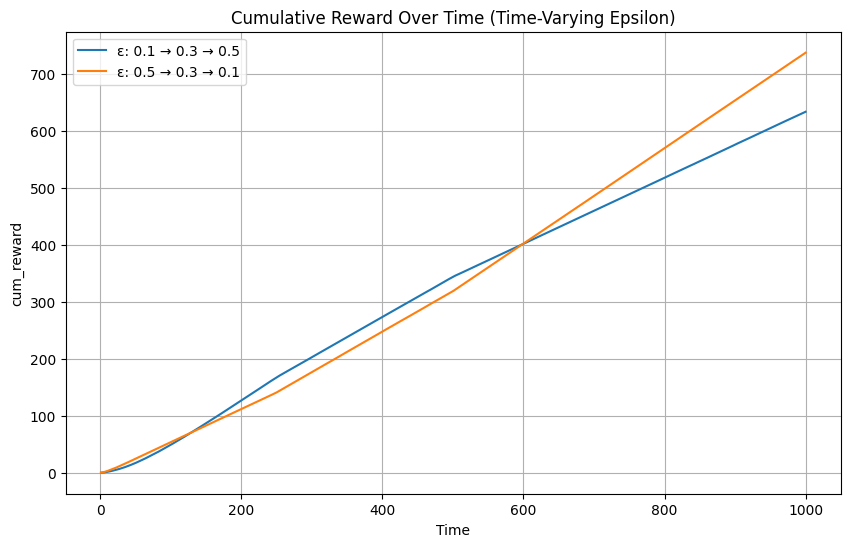

In [ ]:
# 시각화(0.1/0.3/0.5 변화할 때)
plot_best_arm_prob(df_sched, best_arm)
plot_metric(df_sched, "reward", "Average Reward Over Time (Time-Varying Epsilon)")
plot_metric(df_sched, "cum_reward", "Cumulative Reward Over Time (Time-Varying Epsilon)")

## 시간 변화에 따라 0.1/0.3/0.5로 나타내었을때

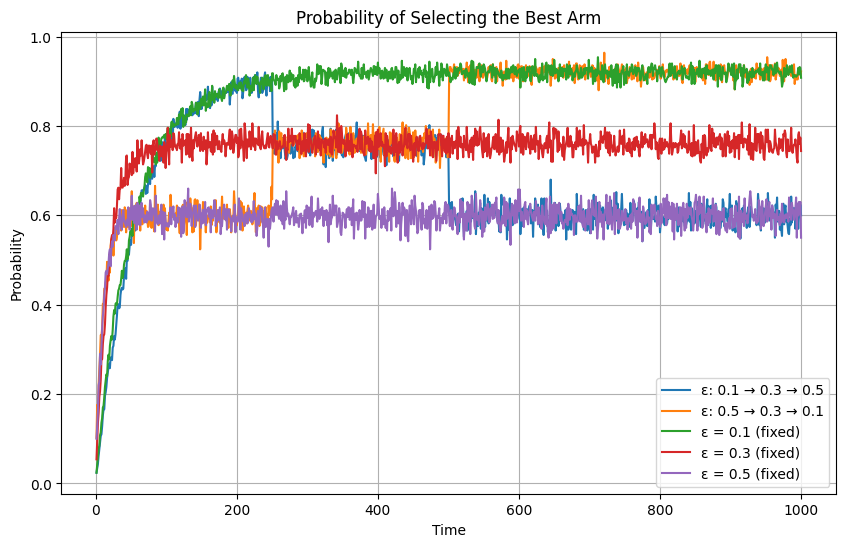

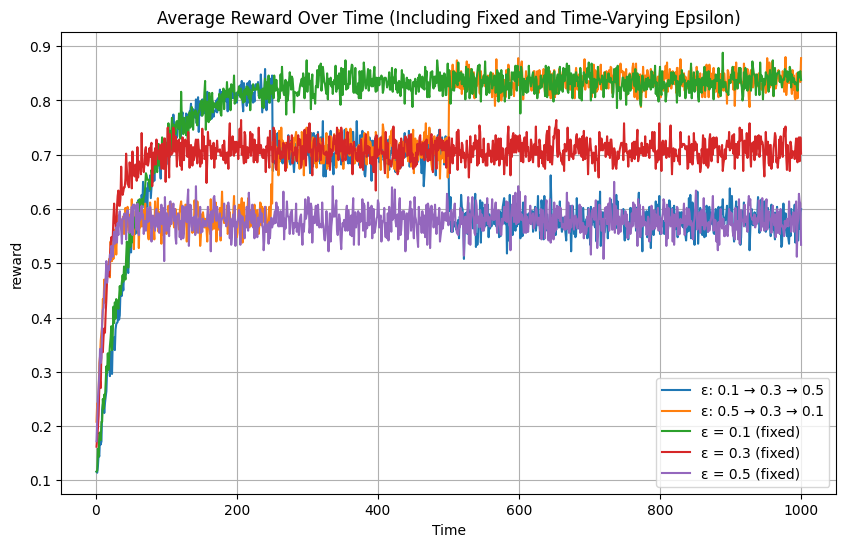

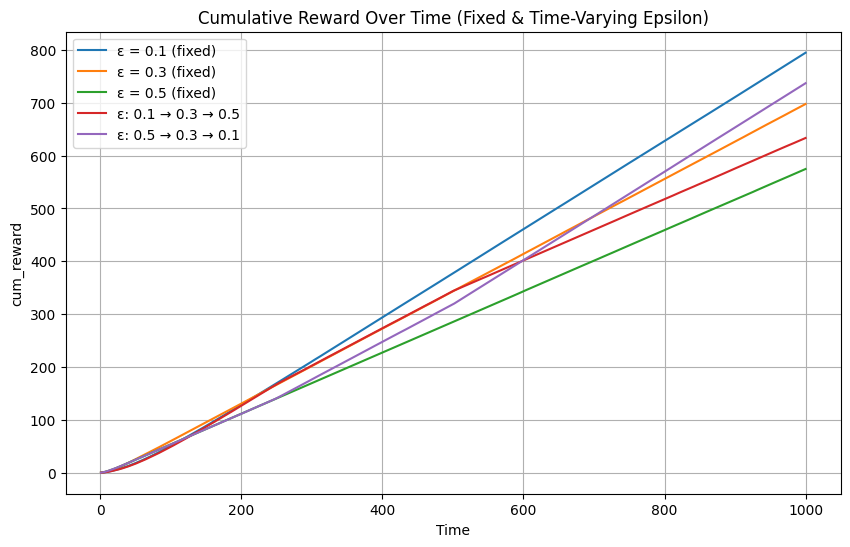

In [16]:
class EpsilonGreedySchedule:
    def __init__(self, schedule):
        """
        schedule: {time_step: epsilon_value} 형태의 dict
        (time_step 이하까지 해당 epsilon 사용)
        """
        self.schedule = schedule

    def initialize(self, n_arms):
        self.counts = [0] * n_arms
        self.values = [0.0] * n_arms
        self.t = 0  # 시간 추적용

    def select_arm(self):
        self.t += 1  # 현재 시간 업데이트
        epsilon = self.get_epsilon(self.t)
        if random.random() > epsilon:
            return self.values.index(max(self.values))
        return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

    def get_epsilon(self, t):
        # 시간에 따라 epsilon 반환
        sorted_keys = sorted(self.schedule.keys())
        for k in sorted_keys:
            if t <= k:
                return self.schedule[k]
        return self.schedule[sorted_keys[-1]]  # 가장 마지막 값을 기본으로

## New_0521 ##
# 고정 epsilon 실험 실행 (ε = 0.1, 0.3, 0.5)
df_fixed_list = []
for eps in [0.1, 0.3, 0.5]:
    algo = EpsilonGreedy(eps)
    df_fixed = test_algorithm(algo, arms, num_sims, horizon, f"ε = {eps} (fixed)")
    df_fixed_list.append(df_fixed)

# 기존 시간 가변 epsilon 실험과 병합
df_combined = pd.concat(df_fixed_list + [df1, df2])

# 예전 코드에서 만든 고정 ε 데이터 리스트 df_fixed_list가 있다고 가정
df_fixed_all = pd.concat(df_fixed_list)  # ε = 0.1, 0.3, 0.5 고정 실험들

# 시간 가변 ε 데이터와 합치기
df_all_for_plot = pd.concat([df_sched, df_fixed_all])

# 누적 보상 시각화
plot_best_arm_prob(df_all_for_plot, best_arm)
plot_metric(df_all_for_plot, "reward", "Average Reward Over Time (Including Fixed and Time-Varying Epsilon)")
plot_metric(df_combined, "cum_reward", "Cumulative Reward Over Time (Fixed & Time-Varying Epsilon)")

## t=1 부터 시작해서 한단위 증가할때마다 ε =0.1 부터 0.02씩 증가하는 ɛ-greedy 알고리즘 구현

✅ 1. 스케줄 딕셔너리 생성 (t=1 ~ horizon까지)
min(..., 1.0)은 ε이 최대 1.0을 넘지 않게 제한

t=1 → ε=0.1
t=2 → ε=0.12
t=3 → ε=0.14
...
t=46 → ε=1.0
t=47~1000 → ε=1.0으로 고정



In [ ]:
# 0.1부터 시작해서 0.02씩 증가하는 스케줄 생성
epsilon_schedule = {t: min(0.1 + 0.02 * (t - 1), 1.0) for t in range(1, horizon + 1)}

✅ 2. 스케줄형 알고리즘으로 실험 실행

In [ ]:
algo_dynamic = EpsilonGreedySchedule(epsilon_schedule)
df_dynamic = test_algorithm(algo_dynamic, arms, num_sims, horizon, "ε = 0.1 → 1.0 (increasing)")

✅ 3. 전체 실험 결과에 추가 & 시각화

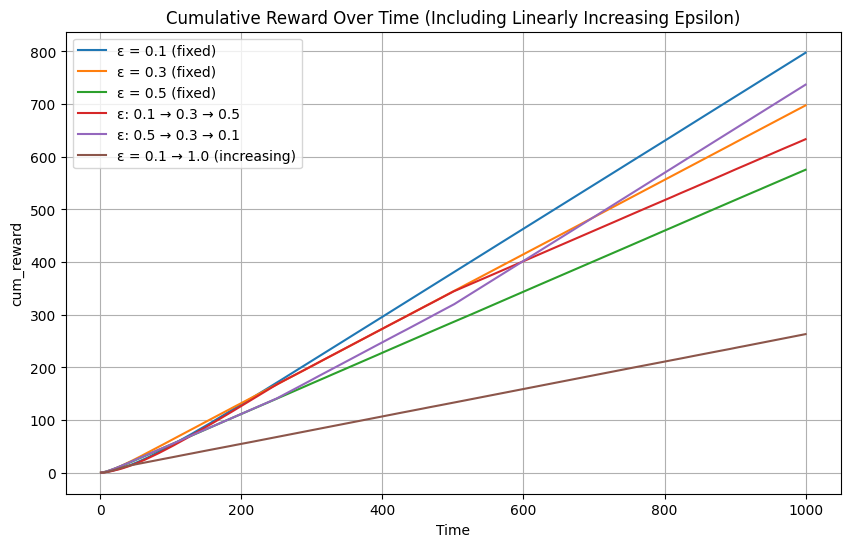

In [ ]:
# 이전 고정 및 시간 스케줄 실험 결과와 병합
df_combined_all = pd.concat([df_combined, df_dynamic])

# 누적 보상 시각화
plot_metric(df_combined_all, "cum_reward", "Cumulative Reward Over Time (Including Linearly Increasing Epsilon)")

####✅ ε-greedy 알고리즘 복습
ε-greedy는 두 가지 행동 사이에서 균형을 잡습니다:

탐험(Exploration): 무작위로 arm 선택 (확률 ε)

활용(Exploitation): 현재까지 가장 성능이 좋은 arm 선택 (확률 1−ε)

즉, ε가 클수록 더 많이 탐험하고, 작을수록 더 많이 활용합니다.

####🔼 ε 증가 전략의 의미
시간이 지날수록 더 많이 탐험한다
#####일반적인 전략은 초기에는 탐험 → 이후에는 활용입니다 (예: ε 감소).

반대로 ε 증가 전략은 시간이 지날수록 더욱 탐험적인 성향을 띕니다.



###🤔 이러한 전략을 사용하는 이유
✔️ 1. 불확실한 환경 또는 비정상(bandit drift) 상황 대응
보상의 분포가 시간이 지남에 따라 바뀌는 환경에서는 초반에 너무 활용하면 초기 추정에 과도하게 의존하게 됨.

후반에도 계속 탐험해야 환경 변화에 적응 가능.

→ 이럴 때 ε 증가 전략이 유용합니다.

✔️ 2. 탐욕적 초기화 방지
일부 arm이 초기에 운 좋게 높은 보상을 주면,ε가 낮은 경우 해당 arm에만 의존할 수 있음.

시간이 지날수록 ε을 높이면, 다른 arm도 점점 더 자주 시도함.

→ **국소 최적(local optimum)**에 빠지지 않도록 도와줌.

✔️ 3. 학습 후반에 불확실성을 적극 탐색
예: 강화학습이나 드리프트 환경에서 후반에도 미지의 상태를 계속 탐색할 필요가 있을 때.



### 📉 단점
최종적으로 ε이 커지면 (탐험 확률 ↑) 성능이 떨어질 수 있음.

무작위 선택이 많아지기 때문.

활용을 잘 해야 하는 후반에, 오히려 성공률 높은 arm을 잘 활용하지 못할 수 있음.